# Predicting Medical Insurance - Training

## Import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
CSV_FILE = '../backend_app/insurance_dataset.csv'
df = pd.read_csv(CSV_FILE)

## Baseline: Dummy model

In [3]:
from sklearn.dummy import DummyRegressor
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import CategoricalImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [4]:
df_full_train, df_test = train_test_split(df, test_size=.2, random_state=10)
df_train, df_val = train_test_split(df_full_train, test_size=.25)
y_train = df_train.charges.values
df_train.drop('charges', axis=1, inplace=True)

y_val = df_val.charges.values
df_val.drop('charges', axis=1, inplace=True)

y_test = df_test.charges.values
df_test.drop('charges', axis=1, inplace=True)

y_full_train = df_full_train.charges.values
df_full_train.drop('charges', axis=1, inplace=True)

In [5]:
OHE_FEATURES = [
    'gender',
    'smoker',
    'region',
    'medical_history',
    'family_medical_history',
    'exercise_frequency',
    'occupation',
    'coverage_level'
]

CATEGORICAL_IMPUTER_FEATURES = ['medical_history', 'family_medical_history']

In [6]:
steps = [
    ('categorical imputer', CategoricalImputer(
        fill_value='Healthy', 
        variables=CATEGORICAL_IMPUTER_FEATURES)
    ),
    ('ohe', OneHotEncoder(variables=OHE_FEATURES, ignore_format=True))
]

pipeline = Pipeline(steps)

processed_train = pipeline.fit_transform(df_train, y_train)
processed_val = pipeline.transform(df_val)

In [7]:
dr = DummyRegressor()

dr.fit(processed_train, y_train)

DummyRegressor()

In [25]:
def evaluate(model, X_train: pd.DataFrame, X_val: pd.DataFrame, y_train: list, y_val: list):
    sns.set()
    
    y_pred_train = model.predict(X_train) 
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    
    y_pred = model.predict(X_val) 
    rmse_val = mean_squared_error(y_val, y_pred, squared=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.subplots_adjust(top=.8)
    
    suptitle = f'''model={model.__class__.__name__}
    {rmse_train=:.3f}
    {rmse_val=:.3f}'''
    
    fig.suptitle(suptitle, fontsize=10)
    
    sns.histplot(y_val - y_pred, label='Validation', ax=ax1, bins=50)
    sns.histplot(y_train - y_pred_train, label='Training', ax=ax1, bins=50, zorder=0)
    ax1.legend()
    
    ax1.set_xlabel('Error distribution')
    
    sns.scatterplot(x=y_val, y=y_pred, ax=ax2)
    lims = [
        min(ax2.get_xlim(), ax2.get_ylim()),
        max(ax2.get_xlim(), ax2.get_ylim())
    ]
    ax2.plot(lims, lims, 'k-', zorder=0, lw=3)
    ax2.set_xlabel('y_val')
    ax2.set_ylabel('y_pred')

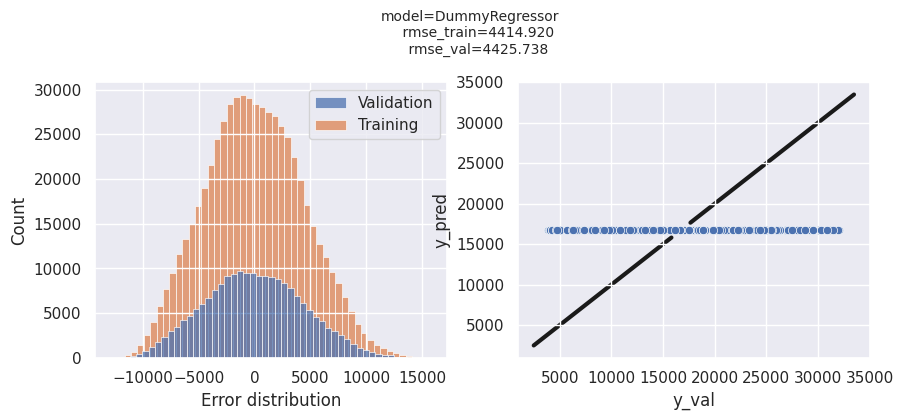

In [26]:
evaluate(dr, df_train, df_val, y_train, y_val)

These results are from a dummy model, indicating that that subsequent models are expected to perform better.

## Feature selection with Recursive Feature Elimination

Recursive Feature elimination will be used to keep the most important features and a Linear Regression model will be used as estimator.

In [27]:
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.linear_model import LinearRegression

Preprocessing full train dataset

In [28]:
pipeline = Pipeline(steps)

processed_full_train = pipeline.fit_transform(df_full_train, y_full_train)

Applying Recursive Feature Elimination

In [12]:
%%time

pipeline = Pipeline(steps=[
    ('feature selection', RecursiveFeatureElimination(
        LinearRegression(),
        cv=3,
        threshold=0.1,
        scoring='neg_root_mean_squared_error'))
])

pipeline.fit(processed_full_train, y_full_train)

CPU times: user 4min 21s, sys: 1min 22s, total: 5min 43s
Wall time: 1min 29s


Pipeline(steps=[('feature selection',
                 RecursiveFeatureElimination(estimator=LinearRegression(),
                                             scoring='neg_root_mean_squared_error',
                                             threshold=0.1))])

In [13]:
tr = pipeline[0]
print(type(tr))

<class 'feature_engine.selection.recursive_feature_elimination.RecursiveFeatureElimination'>


In [14]:
#Performance of the model trained using all the features in its attribute:

print(tr.initial_model_performance_*-1)

288.61758715476446


Features to drop after the analysis:

In [15]:
tr.features_to_drop_

['gender_female',
 'smoker_no',
 'region_southeast',
 'medical_history_Diabetes',
 'family_medical_history_Diabetes',
 'exercise_frequency_Occasionally',
 'occupation_Blue collar',
 'coverage_level_Standard']

After trying with different values for `threshold` and `cv` in the RecursiveFeatureElimination, the feature to drop were usually the same. 
Since very few features were returned (some of them being the result of OHE), then all the original features may be used in production.

## Testing other models

Let's test multiple models setting small values in their hyperparameters

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [30]:
RANDOM_STATE = 10

models = [
    LinearRegression(n_jobs=-1),
    DecisionTreeRegressor(max_depth=20, random_state=RANDOM_STATE), 
    RandomForestRegressor(n_estimators=30, max_depth=15, n_jobs=-1, random_state=RANDOM_STATE),
    XGBRegressor(n_estimators=30, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
]

In [31]:
def train_models(models: list)-> dict:
    models_dict = {}
    for model in models:
        model_name: str = model.__class__.__name__
        
        print('Creating pipeline for model:', model_name)
        
        model.fit(processed_train, y_train)
        
        models_dict[model_name] = model
    
    return models_dict

In [32]:
train_models.__annotations__

{'models': list, 'return': dict}

Training models

In [33]:
%%time

models_dict = train_models(models)

Creating pipeline for model: LinearRegression
Creating pipeline for model: DecisionTreeRegressor
Creating pipeline for model: RandomForestRegressor
Creating pipeline for model: XGBRegressor
CPU times: user 5min 18s, sys: 2.59 s, total: 5min 20s
Wall time: 49.2 s


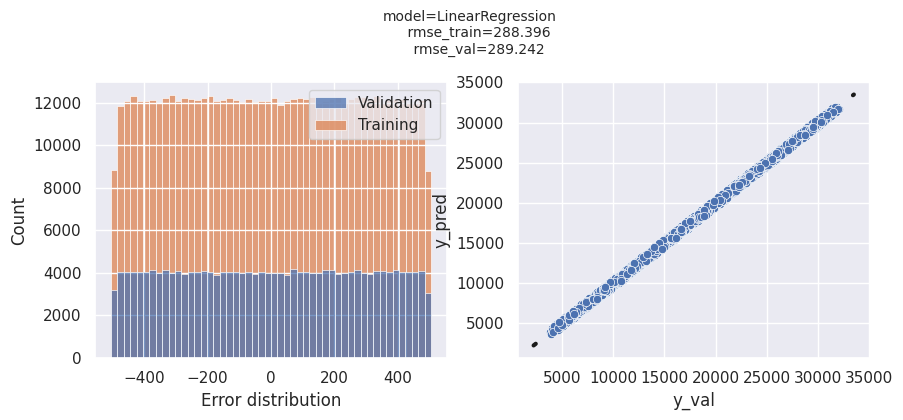

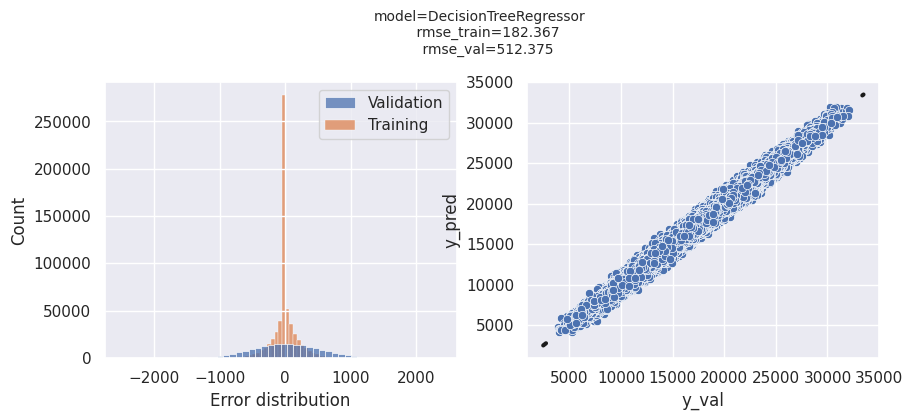

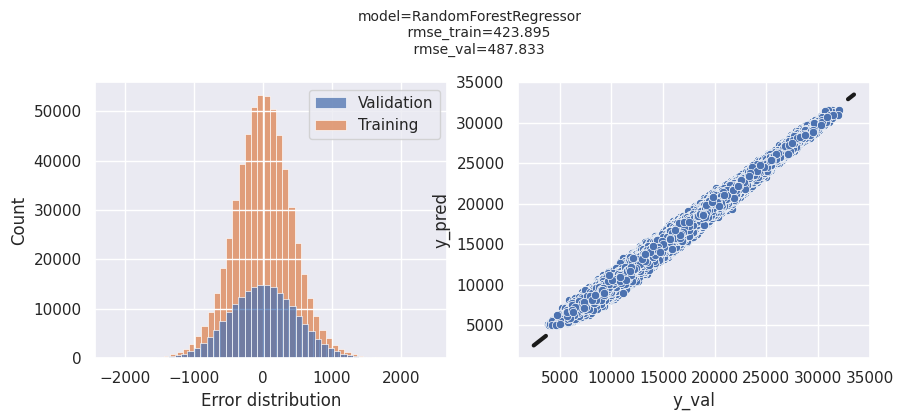

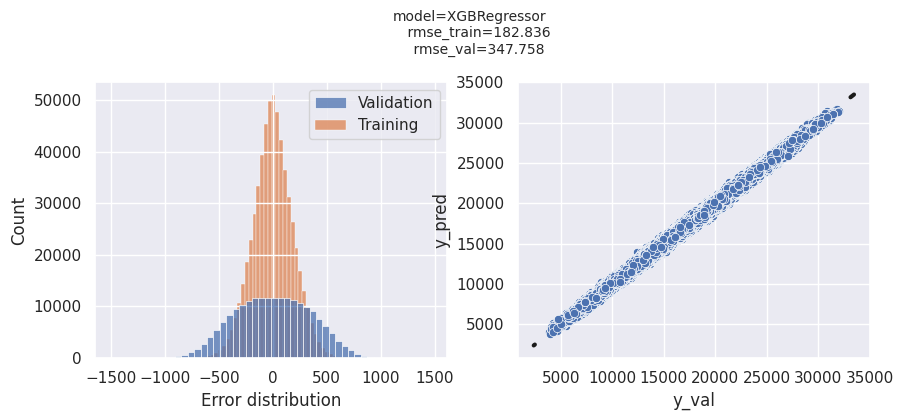

In [34]:
for model in models_dict.values():
    evaluate(model, processed_train, processed_val, y_train, y_val)

LinearRegression model stands out as most efficient option. While `XGBoost` made its best effort by reducing the `RMSE` value but it required a hight number of iterations. Further optimization may improve its performance but it could lead to increased complexity and slower model execution. In contrast, a simple linear regression model yielded better results in less time.

**Checking feature importances for tree-based models**

Now that the pipelines are stored into `pipelines` dictionary, it is possible to check their feature importances

In [22]:
models_dict.keys()

dict_keys(['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor'])

In [23]:
def plot_feature_importances(key: str, top: int = 10):
    model = models_dict[key]
    feature_names = processed_train.columns
    feature_importances_score = model.feature_importances_
    feature_importances = dict(
        sorted(
            zip(feature_names, feature_importances_score), key=lambda x:-x[1]
            )[:top]
        )
    plt.figure(figsize=(3, 6))
    plt.title(key)
    sns.barplot(x = feature_importances.values(), y = list(feature_importances))

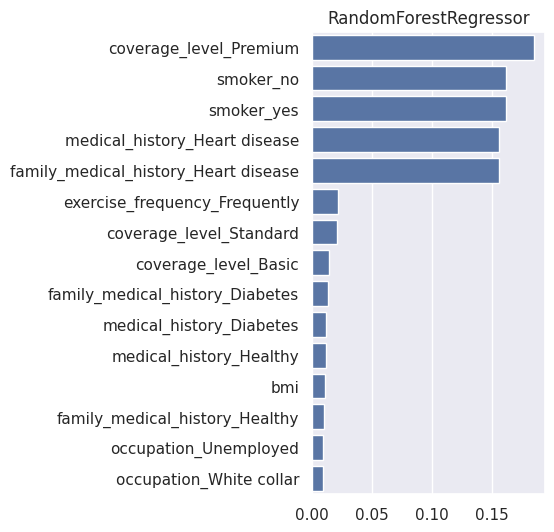

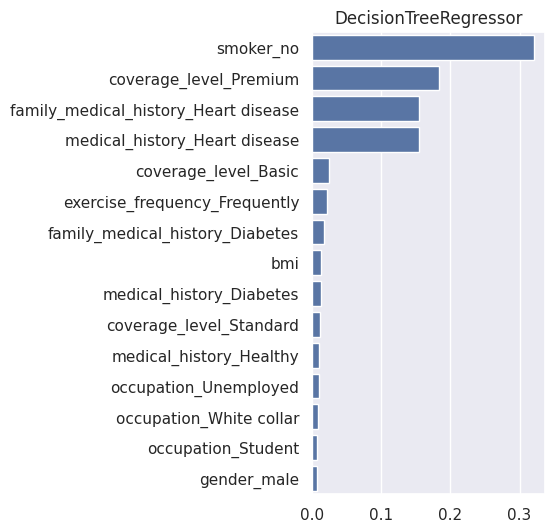

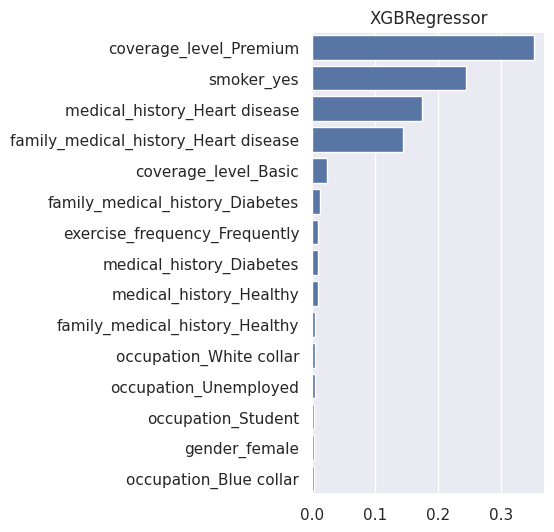

In [24]:
plot_feature_importances('RandomForestRegressor', top=15)
plot_feature_importances('DecisionTreeRegressor', top=15)
plot_feature_importances('XGBRegressor', top=15)

Smoker and coverage level premium look like crutial features to predict the medical insurance charges

## Tuning params

In [25]:
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

As there are only 3 hyperparams to optimize in LinearRegression model, I will create a loop to iterate across different possible values for each them

In [26]:
def optimize_linear_regression(X, y)-> tuple:
    rmse_values = []

    for copy_x in [True, False]:
        for fit_intercept in [True, False]:
            for positive in [True, False]:
                lr = LinearRegression(
                        copy_X=copy_x, 
                        fit_intercept=fit_intercept, 
                        positive=positive, 
                        n_jobs=-1)

                lr.fit(processed_train, y_train)
                y_pred = lr.predict(processed_val)
                rmse = mean_squared_error(y_val, y_pred, squared=False)
                
                rmse_values.append((rmse, copy_x, fit_intercept, positive))
    
    return rmse_values

In [27]:
%%time
rmse_values = optimize_linear_regression(processed_train, y_train)

df_rmse = pd.DataFrame(rmse_values, columns=('rmse', 'copy_x', 'fit_intercept', 'positive'))

CPU times: user 23.9 s, sys: 4.94 s, total: 28.9 s
Wall time: 11.9 s


In [28]:
df_rmse

,rmse,copy_x,fit_intercept,positive
0,288.730765,True,True,True
1,288.733104,True,True,False
2,288.733104,True,False,True
3,288.733104,True,False,False
4,288.730765,False,True,True
5,288.733104,False,True,False
6,288.733104,False,False,True
7,288.733104,False,False,False


Well, there is no significative differences in each rmse value, which was something expected. It also means that I could employ this model with its default parameters.

## Cross-Validation

Cross validation with 20 k-folds

In [29]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

In [30]:
def get_cross_validation_scores(X, y, n_splits: int = 20):
    scoring = make_scorer(lambda y1, y2: mean_squared_error(y1, y2, squared=False))

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = cross_val_score(LinearRegression(), 
                            X, 
                            y, 
                            cv=cv, 
                            verbose=3, 
                            scoring=scoring)
    
    return scores

scores = get_cross_validation_scores(processed_full_train, y_full_train)

[CV] END .............................. score: (test=288.679) total time=   3.9s
[CV] END .............................. score: (test=288.528) total time=   1.5s
[CV] END .............................. score: (test=288.190) total time=   1.4s
[CV] END .............................. score: (test=289.624) total time=   1.4s
[CV] END .............................. score: (test=288.831) total time=   1.5s
[CV] END .............................. score: (test=288.835) total time=   1.2s
[CV] END .............................. score: (test=288.863) total time=   1.2s
[CV] END .............................. score: (test=287.554) total time=   1.2s
[CV] END .............................. score: (test=286.956) total time=   1.2s
[CV] END .............................. score: (test=288.507) total time=   1.4s
[CV] END .............................. score: (test=288.529) total time=   1.2s
[CV] END .............................. score: (test=289.151) total time=   1.2s
[CV] END ...................

In [31]:
scores[:5]

array([288.6792475 , 288.52822632, 288.19027698, 289.62375882,
       288.83083328])

In [32]:
print(f'RMSE scores -- mean: {scores.mean():.3f} +- std: {scores.std():.3f}')

RMSE scores -- mean: 288.615 +- std: 0.683


## Training with full train dataset

In [33]:
def train(X: pd.DataFrame, y: list)-> Pipeline:
    pipeline = Pipeline(steps=[
        ('categorical imputer', CategoricalImputer(fill_value='Healthy', variables=CATEGORICAL_IMPUTER_FEATURES)),
        ('ohe', OneHotEncoder(variables=OHE_FEATURES, ignore_format=True)),
        ('lr', LinearRegression(n_jobs=-1))
    ])

    pipeline.fit(X, y)
    
    return pipeline

In [34]:
%%time

pipeline = train(df_full_train, y_full_train)

CPU times: user 10.7 s, sys: 1.92 s, total: 12.6 s
Wall time: 9.23 s


## Evaluation in Test dataset

In [35]:
y_pred = pipeline.predict(df_test)
rmse = mean_squared_error(y_pred, y_test, squared=False)
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 289.147


## Persisting model

In [46]:
import pickle
from pathlib import Path

In [36]:
def persist_pipeline(pipeline, path: Path)-> str:
    with open(path, 'wb') as pkl_file:
        pickle.dump(pipeline, pkl_file)
    return path.as_posix()

def load_pipeline(path: Path)-> Pipeline:
    with open(path, 'rb') as pkl_file:
        return pickle.load(pkl_file)

In [37]:
#current_directory = Path(__file__).parent
current_directory = Path('training.ipynb').parent

persist_pipeline(pipeline, current_directory/'pipeline.pkl')

'pipeline.pkl'

In [38]:
pipeline = load_pipeline(current_directory/'pipeline.pkl')

## Testing with a feature vector

In [39]:
customer = df_test.iloc[0].to_dict()
customer

{'age': 31,
 'gender': 'female',
 'bmi': 42.78,
 'children': 1,
 'smoker': 'yes',
 'region': 'northeast',
 'medical_history': 'Heart disease',
 'family_medical_history': nan,
 'exercise_frequency': 'Rarely',
 'occupation': 'White collar',
 'coverage_level': 'Basic'}

In [40]:
def predict(customer: dict)-> float:
    df_customer = pd.DataFrame(customer, index=[0])
    prediction = pipeline.predict(df_customer)[0]
    return round(prediction, 3)

predicted_charges = predict(customer)

In [41]:
real_charges = round(y_test[0], 3)

In [42]:
print(f'The predicted medical insurance charge for the customer is ${predicted_charges:,}')
print(f'The real medical insurance charge for this customer is ${real_charges:,}')

The predicted medical insurance charge for the customer is $18,457.808
The real medical insurance charge for this customer is $18,687.399
